# Face Area Calculations

Computing and working with face areas is important for the analysis of unstructured grids, with many algorithms and workflows requiring them. This section will showcase the different face area calculation options provided with UXarray:

1. Calculate Total Face Area
2. Options for `Grid.calculate_total_face_area` Function
3. Getting Area of Individual Faces
4. Calculate Area of a Single Triangle in Cartesian Coordinates
5. Calculate Area from Multiple Faces in Spherical Coordinates
6. Demonstrate Area Correction at Line of Constant Lattitude

In [15]:
import uxarray as ux
import numpy as np

We will be using the `outCSne30.ug` grid file, which is encoded in the UGRID convention.

In [16]:
base_path = "../../test/meshfiles/"
grid_path = base_path + "/ugrid/outCSne30/outCSne30.ug"

ugrid = ux.open_grid(grid_path)
ugrid

<uxarray.Grid>
Original Grid Type: UGRID
Grid Dimensions:
  * n_node: 5402
  * n_face: 5400
  * n_max_face_nodes: 4
  * n_nodes_per_face: (5400,)
Grid Coordinates (Spherical):
  * node_lon: (5402,)
  * node_lat: (5402,)
Grid Coordinates (Cartesian):
Grid Connectivity Variables:
  * face_node_connectivity: (5400, 4)
Grid Descriptor Variables:
  * n_nodes_per_face: (5400,)

## 1. Calculate Total Face Area
We can calculate the total face area by calling the function `Grid.calculate_total_face_area()`. Since our dataset lies on the unit sphere, our expected area is 4π, which is approximately 12.56

In [17]:
t4_area = ugrid.calculate_total_face_area()
t4_area

np.float64(12.566370614678554)

## 2. Options for `Grid.calculate_total_face_area` Function

By default, `Grid.calculate_total_face_area` uses a Triangular Quadrature Rule and an Order of 4. However, you can specify the Quadrature Rule and Order as follows:


**Order:**

       1 to 10              for gaussian

       1, 4, 8, 10 and 12   for triangular


In [18]:
t1_area = ugrid.calculate_total_face_area(quadrature_rule="triangular", order=1)
t1_area

np.float64(12.571403993719983)

For the result above, notice that the area is slightly different than the first calculation we made.

Now we use Triangular Quadrature Rule and Order 1

Using a lower order is faster, but at the sacrifice of accuracy.

Generally, gaussian quadrature rule is more accurate than the triangular quadrature rule. Additionally, a higher order comes at the cost of computation time, but produces a more accurate result. See `uxarray/grid/area.py` file and function `get_gauss_quadratureDG` for details on quadrature points and weights.

## 3. Getting Area of Individual Faces

We can access the Grid attribute `Grid.face_area` to access the individual face areas. If you have not run a face area calculation yet, it will run the `Grid.compute_face_areas` and cache the value.



In [19]:
ugrid.face_areas

<xarray.DataArray 'face_areas' (n_face: 5400)> Size: 43kB
array([0.00211174, 0.00211221, 0.00210723, ..., 0.00210723, 0.00211221,
       0.00211174])
Dimensions without coordinates: n_face
Attributes:
    cf_role:    face_areas
    long_name:  Area of each face.

Now calculate the area again with the `Grid.compute_face_areas` function using arguments: quadrature_rule "gaussian" and order 4

In [20]:
all_face_areas, all_face_jacobians = ugrid.compute_face_areas(
    quadrature_rule="gaussian", order=4
)
g4_area = all_face_areas.sum()
g4_area

np.float64(12.566370614359112)

Now we compare the values with actual know value and report error for each of the three cases above.

In [21]:
actual_area = 4 * np.pi
diff_t4_area = np.abs(t4_area - actual_area)
diff_t1_area = np.abs(t1_area - actual_area)
diff_g4_area = np.abs(g4_area - actual_area)

diff_t1_area, diff_t4_area, diff_g4_area

(np.float64(0.005033379360810386),
 np.float64(3.1938185429680743e-10),
 np.float64(6.039613253960852e-14))

As we can see, it is clear that the Gaussian Quadrature Rule with Order 4 is the most accurate, and the Triangular Quadrature Rule with Order 1 is the least accurate.


## 4. Calculate Area of a Single Triangle in Cartesian Coordinates

For this section, we create a single triangle face with 3 vertices. By default, in `uxarray`, we assume that the coordinate system is spherical (lat / lon), however if you want to use cartesian coordinates, you must pass through `latlon = False` into the `Grid` constructor.

Assume the units in meters - this is a big triangle!

In [22]:
verts = [
    [
        [0.57735027, -5.77350269e-01, -0.57735027],
        [0.57735027, 5.77350269e-01, -0.57735027],
        [-0.57735027, 5.77350269e-01, -0.57735027],
    ]
]

# load our vertices into a UXarray Grid object
vgrid = ux.open_grid(verts, latlon=False)

vgrid

<uxarray.Grid>
Original Grid Type: Face Vertices
Grid Dimensions:
  * n_node: 3
  * n_face: 1
  * n_max_face_nodes: 3
  * n_nodes_per_face: (1,)
Grid Coordinates (Spherical):
Grid Coordinates (Cartesian):
  * node_x: (3,)
  * node_y: (3,)
  * node_z: (3,)
Grid Connectivity Variables:
  * face_node_connectivity: (1, 3)
Grid Descriptor Variables:
  * n_nodes_per_face: (1,)

In [23]:
vgrid.calculate_total_face_area()

np.float64(1.0719419938548218)

Additionally, if you are using a unit other than meters, you can update the units as follows

In [24]:
# Calculate the area of the triangle
area_gaussian = vgrid.calculate_total_face_area(quadrature_rule="gaussian", order=5)
area_gaussian

np.float64(1.0475702709086991)

## 5. Calculate Area from Multiple Faces in Spherical Coordinates

Similar to above, we can construct a `Grid` object with multiple faces by passing through a set of vertices. Here we define 3 six-sided faces.

In [25]:
faces_verts_ndarray = np.array(
    [
        np.array(
            [
                [150, 10, 0],
                [160, 20, 0],
                [150, 30, 0],
                [135, 30, 0],
                [125, 20, 0],
                [135, 10, 0],
            ]
        ),
        np.array(
            [
                [125, 20, 0],
                [135, 30, 0],
                [125, 60, 0],
                [110, 60, 0],
                [100, 30, 0],
                [105, 20, 0],
            ]
        ),
        np.array(
            [
                [95, 10, 0],
                [105, 20, 0],
                [100, 30, 0],
                [85, 30, 0],
                [75, 20, 0],
                [85, 10, 0],
            ]
        ),
    ]
)

We want our units to be spherical, so we pass through `latlon=True`. Additionally, if `latlon` is not passed through, it will default to spherical coordinates.

In [26]:
verts_grid = ux.open_grid(faces_verts_ndarray, latlon=True)

verts_grid

<uxarray.Grid>
Original Grid Type: Face Vertices
Grid Dimensions:
  * n_node: 14
  * n_face: 3
  * n_max_face_nodes: 6
  * n_nodes_per_face: (3,)
Grid Coordinates (Spherical):
  * node_lon: (14,)
  * node_lat: (14,)
Grid Coordinates (Cartesian):
Grid Connectivity Variables:
  * face_node_connectivity: (3, 6)
Grid Descriptor Variables:
  * n_nodes_per_face: (3,)

In [27]:
area, jacobian = verts_grid.compute_face_areas()
area

array([0.14323746, 0.25118746, 0.12141312])

## 6. Area Correction

### Correction Formula

The correction, $A$, is calculated using the following formula:

\begin{align}
A = 2 \arctan \left[ \frac{z (x_1 y_2 - x_2 y_1)}{x_1^2 + y_1^2 + x_1 x_2 + y_1 y_2} \right] - z \arctan \left[ \frac{x_1 y_2 - x_2 y_1}{x_1 x_2 + y_1 y_2} \right].
\end{align}

**Where:**

- $(x_1, y_1, z)$ are the Cartesian coordinates of the first node.
- $(x_2, y_2, z)$ are the Cartesian coordinates of the second node (note that the $z$ coordinate is the same for both nodes).

**Assumptions:**

- This formula assumes that the input coordinates $(x_1, y_1)$ and $(x_2, y_2)$ are normalized (i.e., they lie on the unit sphere).
  
#### For the same big triangle as used in Section 4, we calculate area correction term when an edge is at the line of constant latitude. The code below plots that triangle and marks the edges with different colors, highlights the edge at the line of constant latitude and also marks the coordinates of the vertices.

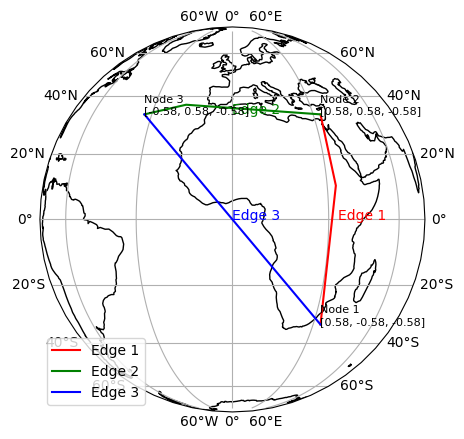

In [30]:
%matplotlib inline 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Convert the points to latitude and longitude
points = [
    (point[0] * 180 / 3.14159, point[1] * 180 / 3.14159)
    for vert in verts
    for point in vert
]

# Node names
node_names = ["Node 1", "Node 2", "Node 3"]

# Edge names and colors
edge_names = ["Edge 1", "Edge 2", "Edge 3"]
edge_colors = ["red", "green", "blue"]

# Create a new figure
fig = plt.figure(figsize=(10, 5))

# Create a GeoAxes in the Orthographic projection
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=0))

# Add coastlines and gridlines for reference
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=True)

# Plot the points, edges, and labels
for i in range(len(points)):
    lon1, lat1 = points[i]
    lon2, lat2 = points[(i + 1) % len(points)]

    # Plot the edge
    ax.plot(
        [lon1, lon2],
        [lat1, lat2],
        color=edge_colors[i],
        transform=ccrs.Geodetic(),
        label=edge_names[i],
    )

    # Add edge label (adjust the offset as needed)
    ax.text(
        (lon1 + lon2) / 2,
        (lat1 + lat2) / 2,
        edge_names[i],
        transform=ccrs.Geodetic(),
        color=edge_colors[i],
    )

    # Add node label with Cartesian coordinates
    cartesian_coords = verts[0][i]  # Get Cartesian coordinates from verts
    label = f"{node_names[i]}\n[{cartesian_coords[0]:.2f}, {cartesian_coords[1]:.2f}, {cartesian_coords[2]:.2f}]"
    ax.text(lon1, lat1, label, transform=ccrs.Geodetic(), fontsize=8, color="black")

# Show the full globe
ax.set_global()

# Add a legend for the edges
plt.legend()

# Display the plot
plt.show()

In [ ]:
# Area of the triangle with correction
area, jacobian = vgrid.compute_face_areas(quadrature_rule="gaussian", order=5)
area

### The above code shows area calculation without any correction term. Next code block calculates the corrected area of the triangle. Two edges (Edge 2 - blue and Edge 3 - green) of the triangle are along the line of constant latitude. 1.047 (no correction) + 2*0.140 (correction term) gives us the right area of the triangle as shown above. Edge 3 - red is also along the line of constant latitude, but also passes through the poles, so it is not considered for the correction term. Simply passing an argument correct_area = True in the function call will calculate the area with the correction for line of constant latitude.

In [ ]:
# Continuing with our example from above and now we will correct the area
area = vgrid.compute_face_areas(quadrature_rule="gaussian", order=5, correct_area=True)